# Lab6 based on MNIST Fashion Dataset

### HANDLING THE NECESSARY LIBRARIES:
============================================

In [79]:

# Ignoring warnings:
import warnings
warnings.filterwarnings('ignore')


# Taking care of data and matrices :
import numpy as np
import pandas as pd
import math 
import itertools


# Modelling Algos :
from sklearn.neural_network import MLPRegressor

# These are Helpers :
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer , scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score
from sklearn.preprocessing import MinMaxScaler , StandardScaler, LabelEncoder


# Classification libraries for metric evaluation
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  

# Deep Learning libraries
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical

# Visualisation libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configuring the visualisations environment
%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)


### Make Visualizations look better:
==================================

In [80]:
# Centering the all plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""");

# Make Visualizations look better
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plt.rcParams.update(params)

### Importing and Extracting Dataset:
==================================

In [81]:
train = pd.read_csv('MNISTFashion_archive/fashion-mnist_train.csv')
test = pd.read_csv('MNISTFashion_archive/fashion-mnist_test.csv')
df = train.copy()
df_test = test.copy()

In [82]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Features exploration:
=======================

In [83]:
print('Train: ', df.shape)
print('Test: ', df_test.shape)

Train:  (60000, 785)
Test:  (10000, 785)


In [84]:
# Checking categorical class labels
df.label.unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1], dtype=int64)

In [85]:
# Cross checking if there are NaN values because if they exist, then imputation techniques have to be applied
# Train
df.isnull().any().sum()

0

In [86]:
# Test
df_test.isnull().any().sum()

0

### Dataset visualization
=======================

In [87]:
# Dictionary (Key: Value) pairs - Plotting of Random Images
clothing = {0 : 'T-shirt/top',
            1 : 'Trouser',
            2 : 'Pullover',
            3 : 'Dress',
            4 : 'Coat',
            5 : 'Sandal',
            6 : 'Shirt',
            7 : 'Sneaker',
            8 : 'Bag',
            9 : 'Ankle boot'}

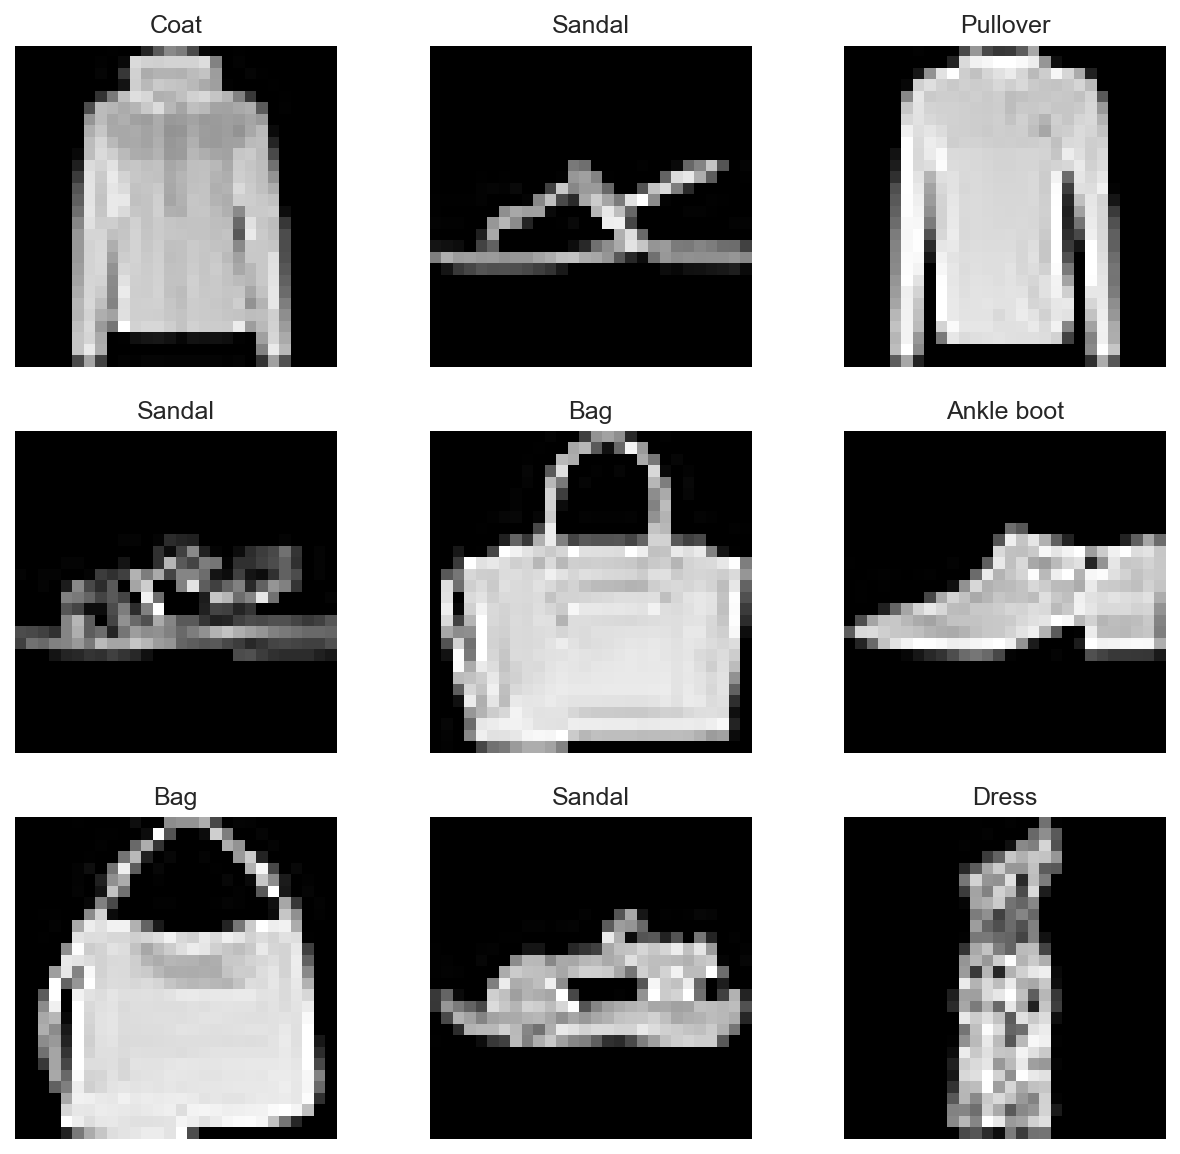

In [88]:
fig, axes = plt.subplots(3, 3, figsize = (9,9))
for row in axes:
    for axe in row:
        index = np.random.randint(60000)
        img = df.drop('label', axis=1).values[index].reshape(28,28)
        cloths = df['label'][index]
        axe.imshow(img, cmap='gray')
        axe.set_title(clothing[cloths])
        axe.set_axis_off()

In [89]:
# Checking Distribution of labels to find out if there are skewed classes
# Incase of skew, then we have to perform OverSampling or UnderSampling as necessary

df['label'].value_counts()

label
2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: count, dtype: int64

### Data Preprocessing
=====================

In [90]:
# Setting Random Seeds.

seed = 66
np.random.seed(seed)

In [94]:
# Splitting Data into Training and validation Set for evaluating the Model's performance on the dataset.

X = train.iloc[:,1:]
Y = train.iloc[:,0]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)


In [95]:
# To reshape the Images from 1D vector each containing 784 pixels.
# We must reshape the data into (28x28x1) 3D matrices as expected by CNN.
# For RGB images, there would have been 3 channels, but as MNIST is gray scale it only uses one.
# The first parameter in reshape indicates the number of examples.
# We pass it as -1, which means that it is an unknown dimension and numpy should figure it out on its own.

# reshape(examples, height, width, channels)
x_train = x_train.values.reshape((-1, 28, 28, 1))
x_test = x_test.values.reshape((-1, 28, 28, 1))

df_test.drop('label', axis=1, inplace=True)
df_test = df_test.values.reshape((-1, 28, 28, 1))






In [96]:
print('Training data shape : ', x_train.shape, y_train.shape)

print('Testing data shape : ', x_test.shape, y_test.shape)

Training data shape :  (48000, 28, 28, 1) (48000,)
Testing data shape :  (12000, 28, 28, 1) (12000,)


In [97]:
# Normalization - 
# The Pixel Values are often stored as Integer Numbers in the range 0 to 255, the range that a single 8-bit byte can offer.
# They need to be scaled down to [0,1] in order for Optimization Algorithms to work much faster. 
# Here, we have to acheive Zero Mean and Unit Variance.

# x = (x - min) / (max - min) --> Here min=0 and max=255
# You need to make sure that your Image is cast into double/float from int before you do this scaling 
# Otherwise, the int values will be truncated to zero 

x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255
df_test = df_test.astype("float32")/255


In [98]:
# One Hot Encoding - The labels are given as integers between 0-9. We need to one hot encode them.

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


In [99]:
print(y_train.shape)
print(y_test.shape)

(48000, 10)
(12000, 10)


### Training a Convolutional Neural Network:
==========================================

In [100]:
# Now that close to 70% of the time was spent on data processing - Let's build the model.

# Building a ConvNet networks or neurons
# We use Sequential Keras API which is just a linear stack of layers. 
# We add one layer at a time starting from input.

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last', input_shape=(28,28,1)))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


# Compiling the networks
# We need to compile the model. We have to specify the optimizer used by the model We have many choices like Adam, RMSprop etc..
# and next we need to specify the loss function for the neural network which we want to minimize.
# For Binary Classification we use "binary_crossentropy" and for Multi-class Classification we use "categorical_crossentropy".
# Refer to Keras doc 

# Optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999 )

# Final Compilation of the model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Learning rate - The Learning rate should be properly tuned , 
# such that it is not too high to take very large steps, neither it should be too small ,
# which would not alter the Weights and Biases.

reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

# Data Augmentation

datagen = ImageDataGenerator(
        rotation_range = 8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        shear_range = 0.3,# shear angle in counter-clockwise direction in degrees  
        width_shift_range=0.08,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.08,  # randomly shift images vertically (fraction of total height)
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

batch_size = 64
epochs = 32


# Fitting the Model and training it 
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size), epochs = epochs, 
                              validation_data = (x_test, y_test), verbose=2, 
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks = [reduce_lr])



Epoch 1/32
750/750 - 361s - loss: 0.8240 - accuracy: 0.7026 - val_loss: 0.4388 - val_accuracy: 0.8380 - lr: 0.0010 - 361s/epoch - 482ms/step
Epoch 2/32
750/750 - 339s - loss: 0.5636 - accuracy: 0.7920 - val_loss: 0.4920 - val_accuracy: 0.8136 - lr: 9.0000e-04 - 339s/epoch - 453ms/step
Epoch 3/32
750/750 - 382s - loss: 0.4785 - accuracy: 0.8265 - val_loss: 0.3311 - val_accuracy: 0.8783 - lr: 8.1000e-04 - 382s/epoch - 509ms/step
Epoch 4/32
750/750 - 353s - loss: 0.4416 - accuracy: 0.8416 - val_loss: 0.3249 - val_accuracy: 0.8792 - lr: 7.2900e-04 - 353s/epoch - 471ms/step
Epoch 5/32
750/750 - 345s - loss: 0.4106 - accuracy: 0.8527 - val_loss: 0.2786 - val_accuracy: 0.8982 - lr: 6.5610e-04 - 345s/epoch - 460ms/step
Epoch 6/32
750/750 - 321s - loss: 0.3952 - accuracy: 0.8590 - val_loss: 0.2737 - val_accuracy: 0.8973 - lr: 5.9049e-04 - 321s/epoch - 428ms/step
Epoch 7/32
750/750 - 225s - loss: 0.3731 - accuracy: 0.8658 - val_loss: 0.2636 - val_accuracy: 0.9038 - lr: 5.3144e-04 - 225s/epoch - 

In [101]:
# Model summary

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_10 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_11 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 dropout_10 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 64)       

### Evaluating the Model:
=======================


In [102]:
score = model.evaluate(x_test, y_test)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

375/375 [==============================] - 19s 51ms/step - loss: 0.1913 - accuracy: 0.9305
Loss: 0.1913
Accuracy: 0.9305


### Plotting the Training and Validation Curves:
============================================

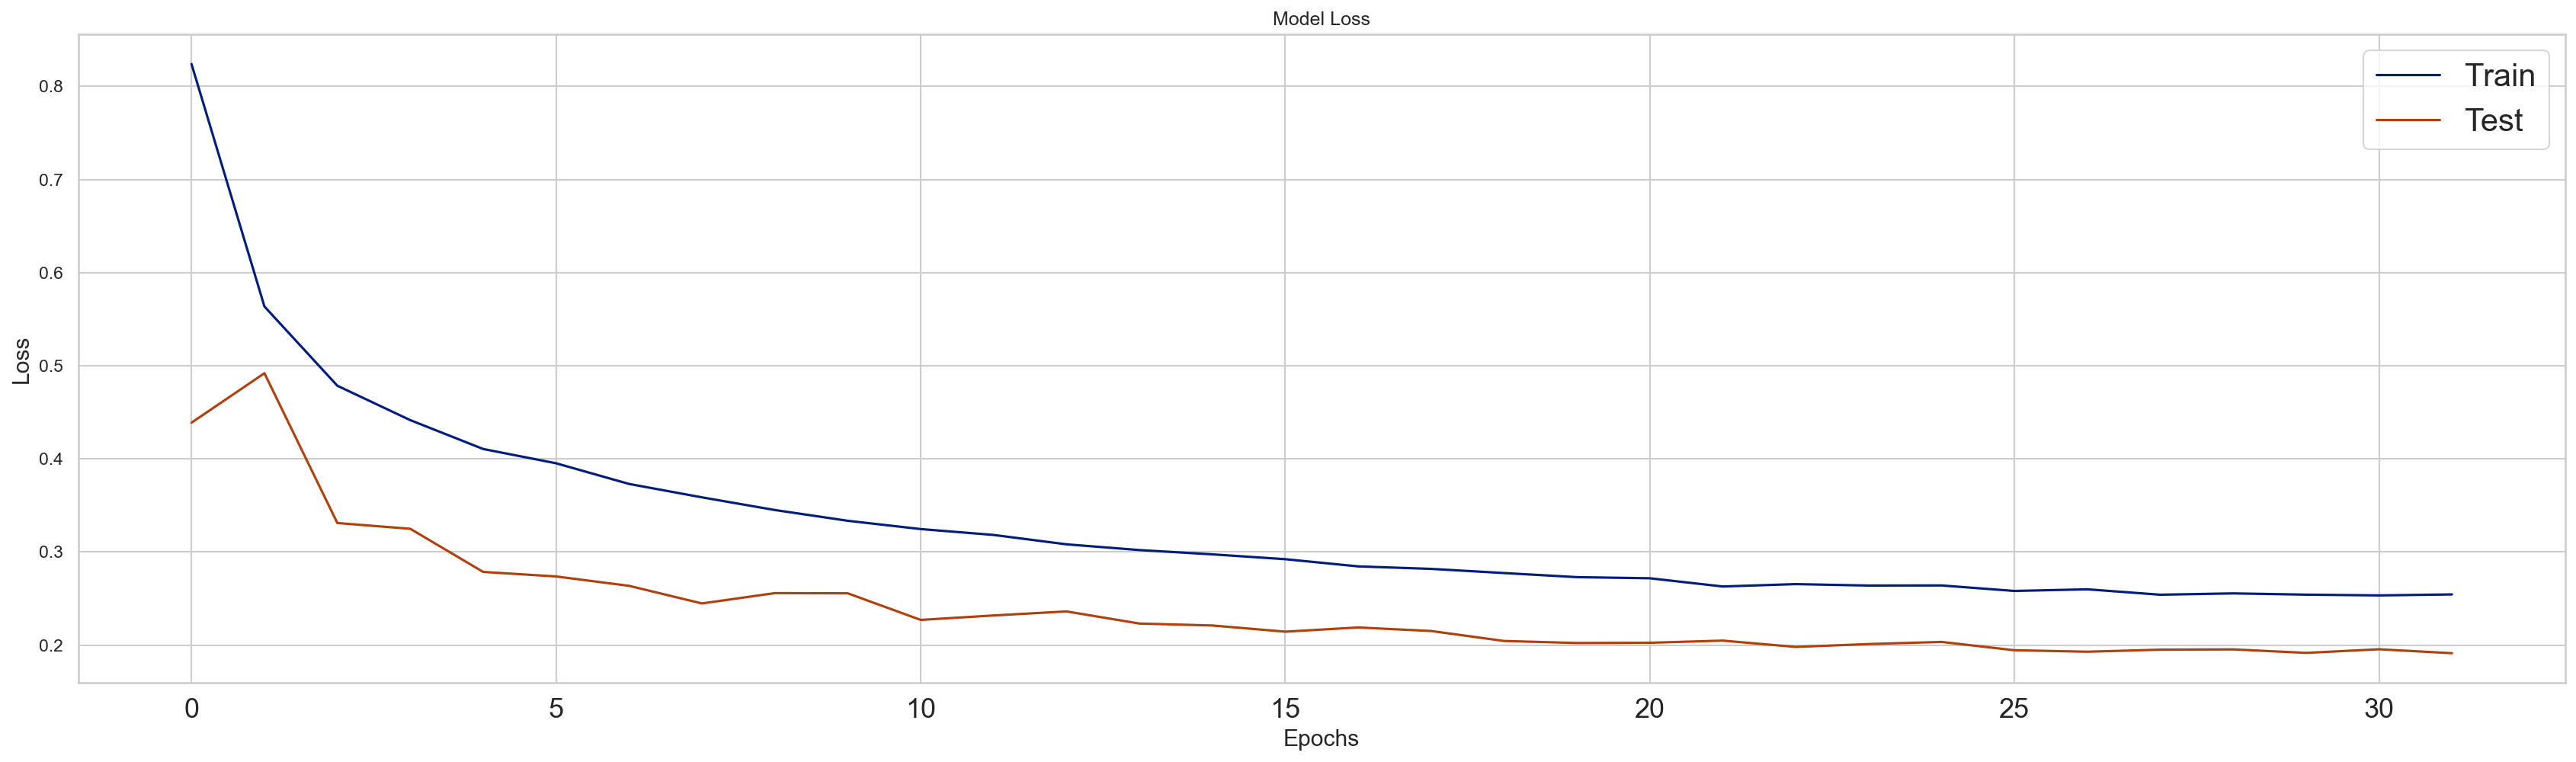

In [103]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

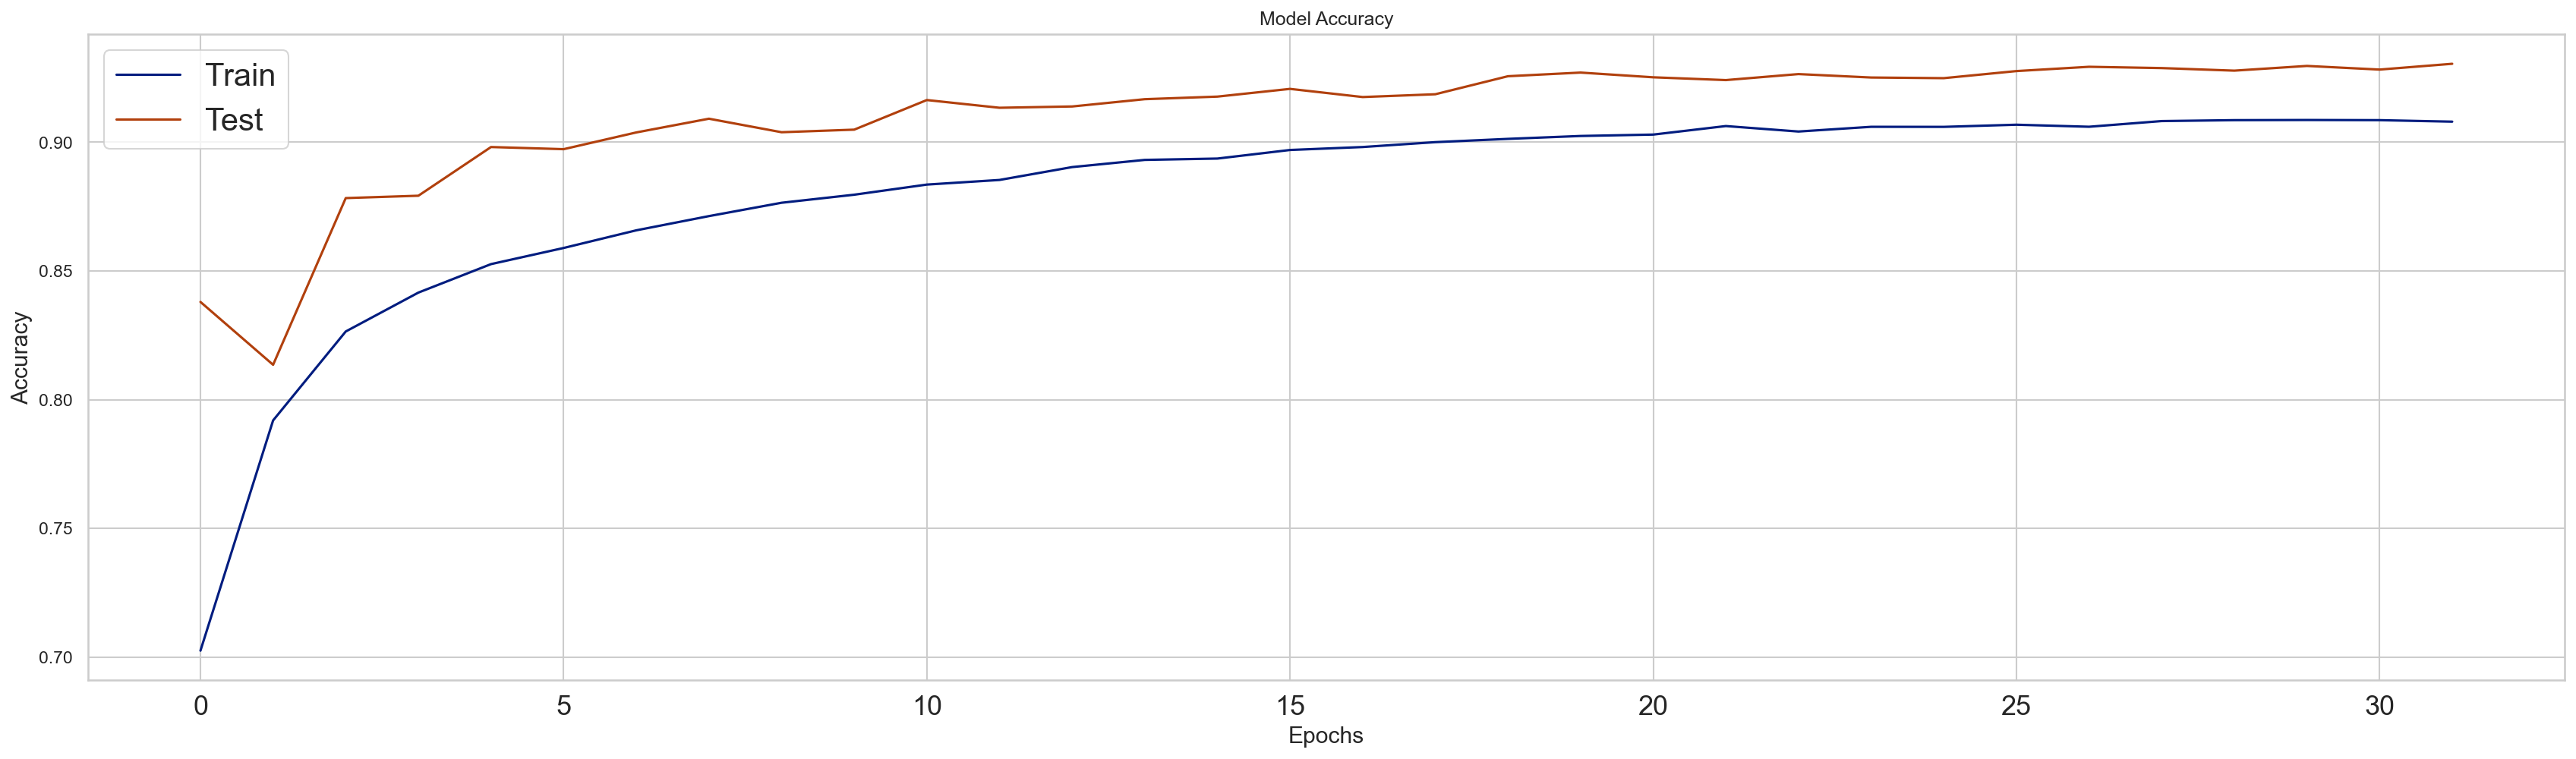

In [106]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

In [108]:
### Confusion Matrix
# ===================

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

375/375 [==============================] - 16s 42ms/step


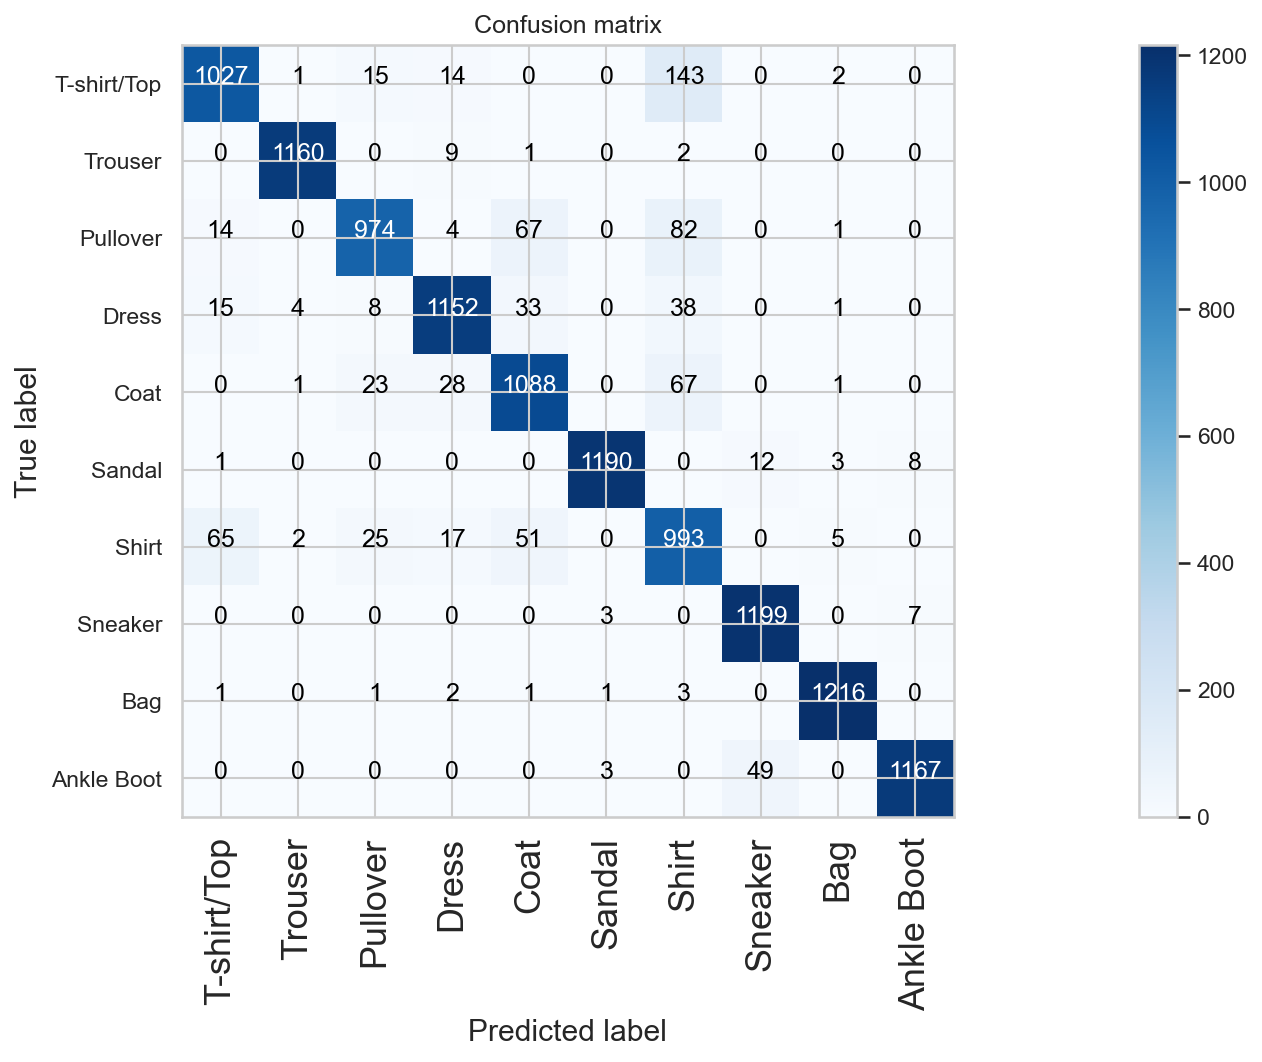

In [109]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, 
            classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])


In [110]:
# We can see that a large number of T-shirt were misclassified as Shirt.


### Visualization of Predicted Classes:
===================================


In [111]:
# Correctly Predicted Classes

correct = []
for i in range(len(y_test)):
    if(Y_pred_classes[i] == Y_true[i]):
        correct.append(i)
    if(len(correct) == 4):
        break

Text(0.5, 1.0, 'Predicted Label : Sandal\nActual Label : Sandal')

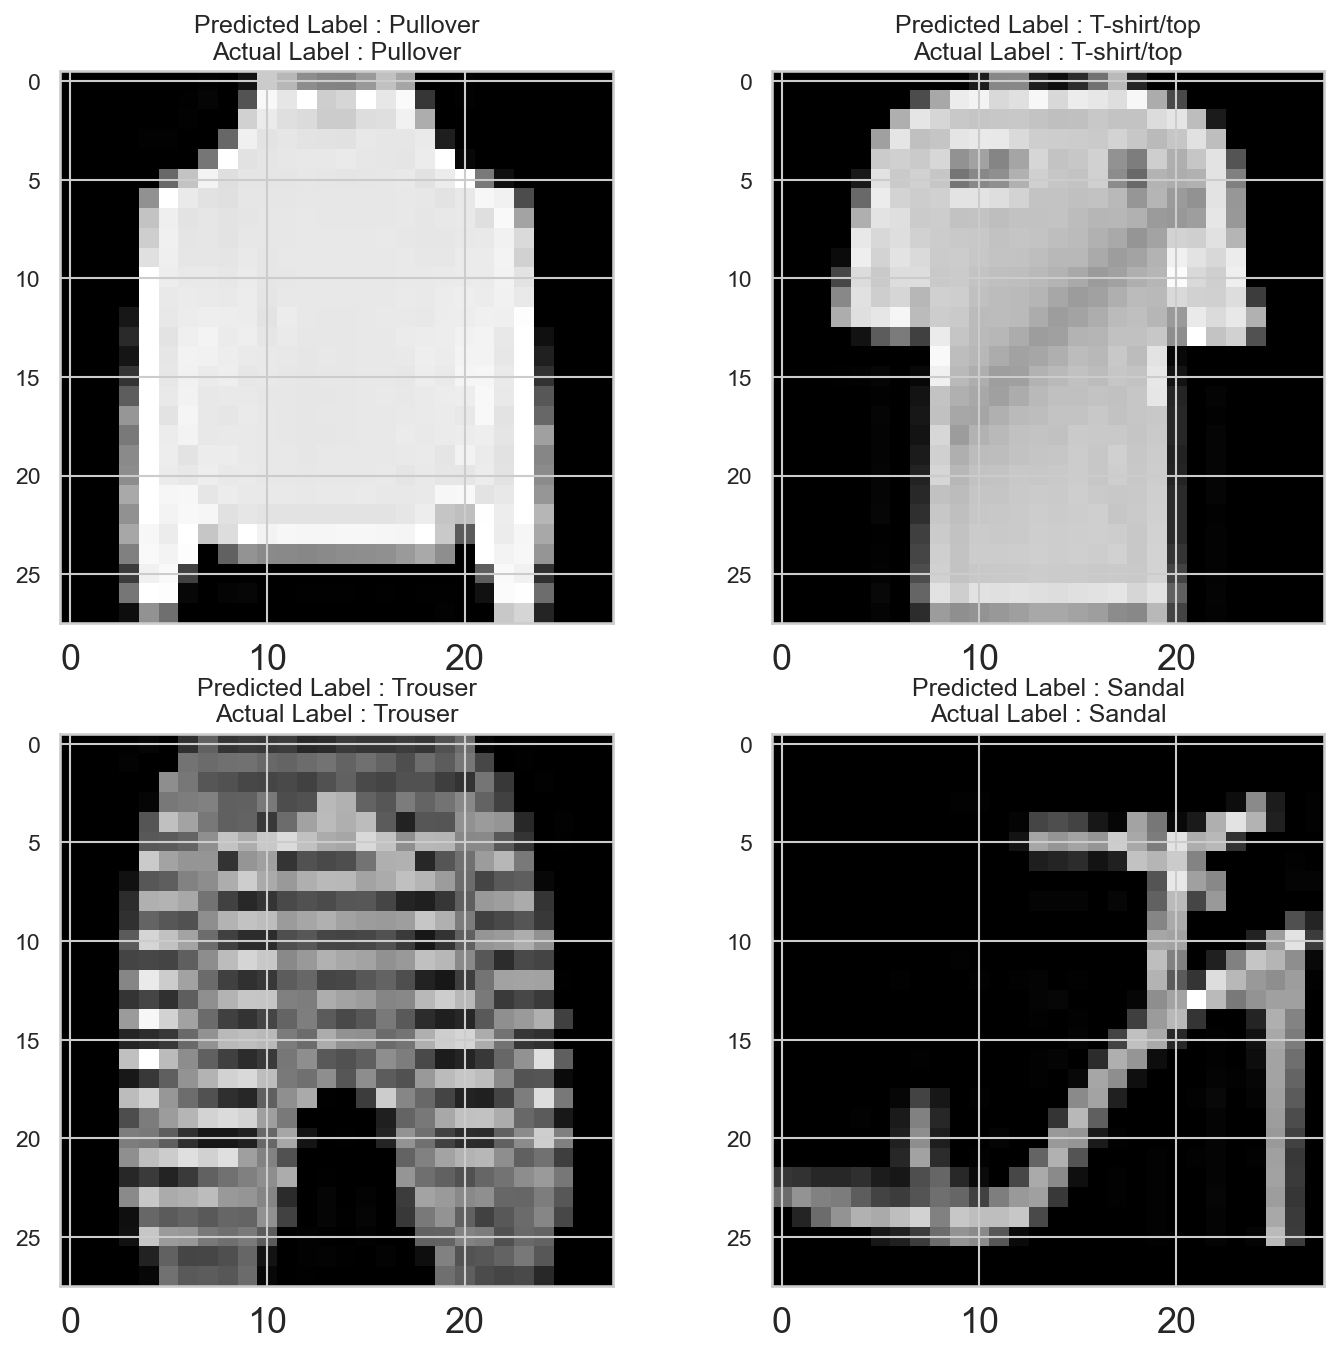

In [112]:
fig, ax = plt.subplots(2,2, figsize=(12,6))
fig.set_size_inches(10,10)
ax[0,0].imshow(x_test[correct[0]].reshape(28,28), cmap='gray')
ax[0,0].set_title("Predicted Label : " + str(clothing[Y_pred_classes[correct[0]]]) + "\n"+"Actual Label : " + 
                 str(clothing[Y_true[correct[0]]]))
ax[0,1].imshow(x_test[correct[1]].reshape(28,28), cmap='gray')
ax[0,1].set_title("Predicted Label : " + str(clothing[Y_pred_classes[correct[1]]]) + "\n"+"Actual Label : " + 
                 str(clothing[Y_true[correct[1]]]))
ax[1,0].imshow(x_test[correct[2]].reshape(28,28), cmap='gray')
ax[1,0].set_title("Predicted Label : " + str(clothing[Y_pred_classes[correct[2]]]) + "\n"+"Actual Label : " + 
                 str(clothing[Y_true[correct[2]]]))
ax[1,1].imshow(x_test[correct[3]].reshape(28,28), cmap='gray')
ax[1,1].set_title("Predicted Label : " + str(clothing[Y_pred_classes[correct[3]]]) + "\n"+"Actual Label : " + 
                 str(clothing[Y_true[correct[3]]]))

In [113]:
# Incorrectly Predicted Classes

incorrect = []
for i in range(len(y_test)):
    if(not Y_pred_classes[i] == Y_true[i]):
        incorrect.append(i)
    if(len(incorrect) == 4):
        break

Text(0.5, 1.0, 'Predicted Label : Shirt\nActual Label : T-shirt/top')

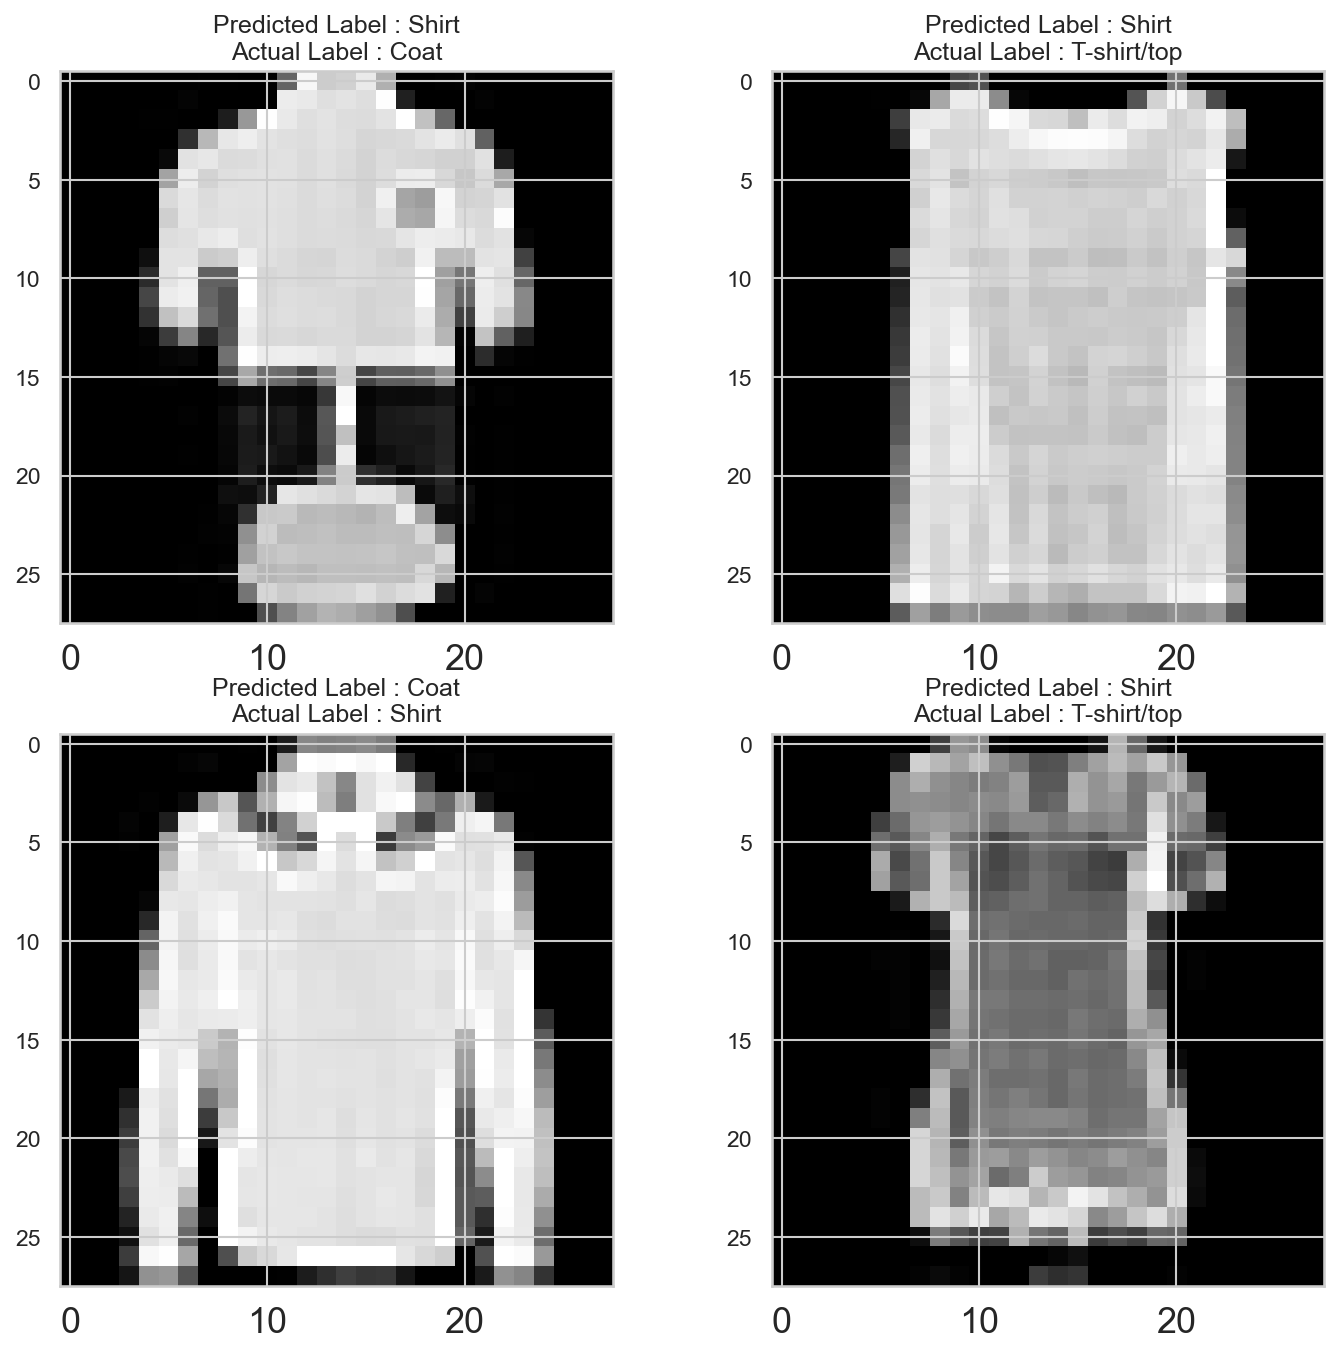

In [114]:
fig, ax = plt.subplots(2,2, figsize=(12,6))
fig.set_size_inches(10,10)
ax[0,0].imshow(x_test[incorrect[0]].reshape(28,28), cmap='gray')
ax[0,0].set_title("Predicted Label : " + str(clothing[Y_pred_classes[incorrect[0]]]) + "\n"+"Actual Label : " + 
                 str(clothing[Y_true[incorrect[0]]]))
ax[0,1].imshow(x_test[incorrect[1]].reshape(28,28), cmap='gray')
ax[0,1].set_title("Predicted Label : " + str(clothing[Y_pred_classes[incorrect[1]]]) + "\n"+"Actual Label : " + 
                 str(clothing[Y_true[incorrect[1]]]))
ax[1,0].imshow(x_test[incorrect[2]].reshape(28,28), cmap='gray')
ax[1,0].set_title("Predicted Label : " + str(clothing[Y_pred_classes[incorrect[2]]]) + "\n"+"Actual Label : " + 
                 str(clothing[Y_true[incorrect[2]]]))
ax[1,1].imshow(x_test[incorrect[3]].reshape(28,28), cmap='gray')
ax[1,1].set_title("Predicted Label : " + str(clothing[Y_pred_classes[incorrect[3]]]) + "\n"+"Actual Label : " + 
                 str(clothing[Y_true[incorrect[3]]]))

### Classification Report:
=======================

In [115]:
classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
print(classification_report(Y_true, Y_pred_classes, target_names = classes))

              precision    recall  f1-score   support

 T-shirt/Top       0.91      0.85      0.88      1202
     Trouser       0.99      0.99      0.99      1172
    Pullover       0.93      0.85      0.89      1142
       Dress       0.94      0.92      0.93      1251
        Coat       0.88      0.90      0.89      1208
      Sandal       0.99      0.98      0.99      1214
       Shirt       0.75      0.86      0.80      1158
     Sneaker       0.95      0.99      0.97      1209
         Bag       0.99      0.99      0.99      1225
  Ankle Boot       0.99      0.96      0.97      1219

    accuracy                           0.93     12000
   macro avg       0.93      0.93      0.93     12000
weighted avg       0.93      0.93      0.93     12000



### Predicting on the Test Data:
==========================

In [116]:
X = df_test
Y = to_categorical(test.iloc[:,0])

In [117]:
score = model.evaluate(X, Y)

print("Loss: {:.4f}".format(score[0]))
print("Accuracy: {:.4f}".format(score[1]))

313/313 [==============================] - 17s 52ms/step - loss: 0.1912 - accuracy: 0.9308
Loss: 0.1912
Accuracy: 0.9308


### Conclusion
Our model predicted 93% of Test Images correctly, which indicates that the model did pretty good job in generalizing the data.

In [119]:
# model.save("fashion_model.h5py")

INFO:tensorflow:Assets written to: fashion_model.h5py\assets


INFO:tensorflow:Assets written to: fashion_model.h5py\assets


In [120]:
pip install pyyaml h5py

Note: you may need to restart the kernel to use updated packages.


In [124]:
from joblib import Parallel, delayed 
import joblib 
  
# Save the model as a pickle in a file 
joblib.dump(model, 'fashion_model.pkl')


['fashion_model.pkl']